variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design m

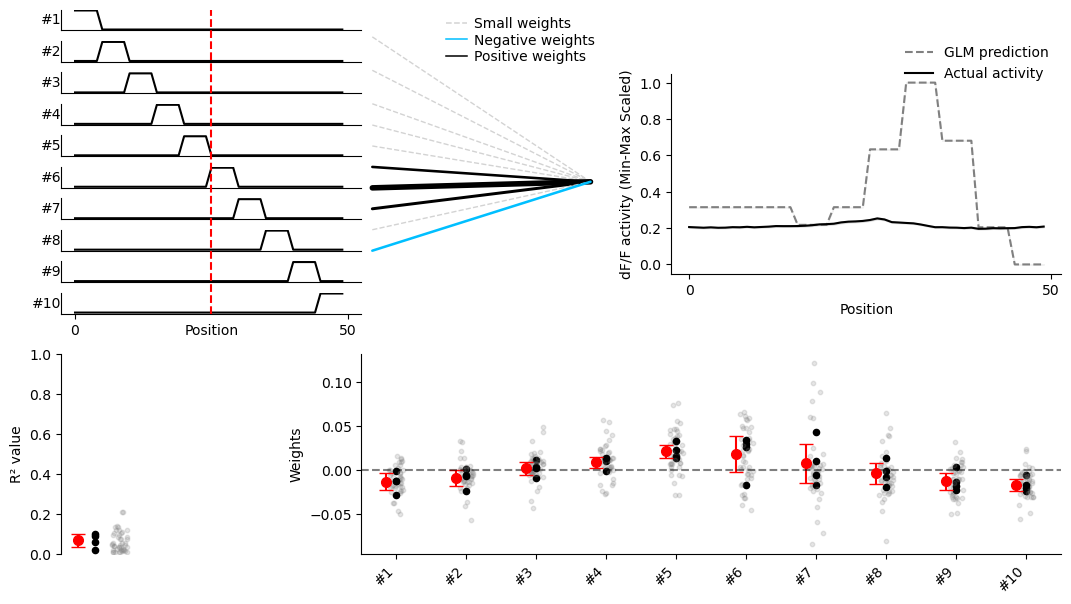

In [6]:
from GLM_regression import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'legend.frameon': False})

# Load data
filepath = "NDNFindivsomata_GLM.mat"
reorganized_data, variable_list = load_data(filepath)
print(f"variable_list: {variable_list}")

def plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None):
    GLM_params = {}

    all_weights = np.zeros(len(variable_list))
    
    if animal == 'best' or neuron == 'best':
        best_R2 = -np.inf
        best_animal = None
        best_neuron = None
        for animal_key in reorganized_data:
            GLM_params[animal_key] = {}
            for i, neuron_data in enumerate(reorganized_data[animal_key]):
                neuron_data = reorganized_data[animal_key][i][:, :, 1:]  # Remove the 0th index (neuron activity)
                neuron_data = neuron_data[:, :, ~np.isnan(neuron_data).any(axis=(0, 1))]

                # Hardcode indices to remove: 0th for activity, next 3 for Licks, R_loc, Speed
                indices_to_remove = [0, 1, 2, 4]
                remaining_indices = list(range(4, neuron_data.shape[1]))
                keep_vars_list = variable_list[remaining_indices]
                
                neuron_data_full = neuron_data.copy()

                # Filter the data to keep only the remaining indices (which represent position)
                neuron_data_filtered = neuron_data[:, remaining_indices, :]

                min_val = np.min(neuron_data, axis=(0, 2), keepdims=True)
                max_val = np.max(neuron_data, axis=(0, 2), keepdims=True)
                neuron_data = (neuron_data - min_val) / (max_val - min_val)

                flattened_data_filtered = []
                for j in range(neuron_data_filtered.shape[1]):
                    flattened_data_filtered.append(neuron_data_filtered[:, j].flatten())

                flattened_data_filtered = np.stack(flattened_data_filtered, axis=1)

                # Combine normalized neuron activity with filtered features
                flattened_data_filtered = np.column_stack((neuron_data[:, 0, :].flatten(), flattened_data_filtered))

                if np.isnan(flattened_data_filtered).any():
                    print("nans in flattened_data_filtered")
                    continue

                if flattened_data_filtered.shape[1] <= 1:
                    print("No features available after preprocessing")
                    continue
    

                neuron_activity_flattened = neuron_data[:, 0, :].flatten()

                # Train GLM using only the position data
                design_matrix_X = flattened_data_filtered[:, 1:]  # Use filtered variables (skip the first column)
                
                neuron_activity_flattened = flattened_data_filtered[:, 0]
                model = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 5000], cv=None)
                model.fit(design_matrix_X, neuron_activity_flattened)

                predicted_activity = model.predict(design_matrix_X)
                predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

                R2 = model.score(design_matrix_X, neuron_activity_flattened)
                pearson_R = np.corrcoef(predicted_activity, neuron_activity_flattened)[0, 1]

                GLM_params[animal_key][i] = {
                    'weights': model.coef_,
                    'intercept': model.intercept_,
                    'R2': R2,
                    'R2_trialavg': pearson_R ** 2,
                    'model': model
                }
                
          

                if R2 > best_R2:
                    best_R2 = R2
                    best_animal = animal_key
                    best_neuron = i

        animal = best_animal
        neuron = best_neuron

        weights = GLM_params[animal][neuron]['weights']
        print(f"shape neuron_data_filtered {neuron_data_filtered.shape}")
        print(f"weights shape: {weights.shape}")
        
        weights[indices_to_remove] = 0 
        
        fig = plt.figure(figsize=(10, 8))

        # GridSpec and subplot setup
        axes = gs.GridSpec(nrows=1, ncols=1, left=0, right=0.3, bottom=0.5)
        ax = fig.add_subplot(axes[0])
        ax.axis('off')
        

#         fig = plt.figure(figsize=(10, 8))
#         axes = gs.GridSpec(nrows=1, ncols=1, left=0, right=0.3, bottom=0.5)
#         ax = fig.add_subplot(axes[0])
#         ax.axis('off')

        # Calculate the average of the selected subset variables (position bins)
        avg_variables = np.mean(neuron_data_filtered, axis=2)
        print(f"  avg_variables shape {avg_variables.shape}")

#         # Generate labels for the position bins
#         spatial_bin_labels = [f"#{i}" for i in range(1, avg_variables.shape[1] + 1)]
#         print(f" spatial_bin_labels {spatial_bin_labels}")
#         if len(spatial_bin_labels) != avg_variables.shape[1]:
#             raise ValueError("Mismatch between number of spatial bin labels and the shape of avg_variables")
            
#         def plotting_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None):
#             fig = ax.get_figure()

#             # Define height ratios for each variable subplot
#             height_ratios = np.ones(len(keep_vars_list))

#             # Set up the grid for subplots
#             axes = gs.GridSpecFromSubplotSpec(nrows=len(keep_vars_list), ncols=1, subplot_spec=ax, hspace=0.5, height_ratios=height_ratios)

#             # Iterate through the variables and plot each one
#             for i in range(len(keep_vars_list)):
#                 sub_ax = fig.add_subplot(axes[i])
#                 sub_ax.plot(avg_variables[:, i], color='k')  # Ensure correct indexing to plot the right variable

#                 # Set labels and ticks
#                 sub_ax.set_ylabel(keep_vars_list[i], rotation=0, ha='right', va='center', labelpad=0)
#                 sub_ax.set_xticks([])
#                 sub_ax.set_yticks([])

#                 # Plot weights as scatter points if provided
#                 if weights is not None:
#                     sub_ax.scatter([50], [0.3], c='k', s=abs(weights[i]) * 20)

#             # Set x-axis labels for the bottom plot
#             sub_ax.set_xlabel('Position', labelpad=-10)
#             sub_ax.set_xticks([0, 50])

#             # Draw vertical line across all plots (for visual separation)
#             overlay_ax = fig.add_subplot(axes[:])
#             overlay_ax.vlines(24.5, 0, 1, linestyles='--', color='r')
#             overlay_ax.set_xlim([0, 49])
#             overlay_ax.set_ylim([0, 1])
#             overlay_ax.axis('off')
#             overlay_ax.patch.set_alpha(0)

#         # Plot the data
#         plotting_example_neuron_variables(avg_variables, spatial_bin_labels, ax=ax, weights=weights)


        def plotting_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None):
            fig = ax.get_figure()

            # Define height ratios for each variable subplot
            height_ratios = np.ones(len(keep_vars_list))

            # Set up the grid for subplots
            axes = gs.GridSpecFromSubplotSpec(nrows=len(keep_vars_list), ncols=1, subplot_spec=ax, hspace=0.5, height_ratios=height_ratios)

            # Iterate through the variables and plot each one
            for i in range(len(keep_vars_list)):
                sub_ax = fig.add_subplot(axes[i])
                sub_ax.plot(avg_variables[:, i], color='k')  # Ensure correct indexing to plot the right variable

                # Set labels and ticks
                sub_ax.set_ylabel(keep_vars_list[i], rotation=0, ha='right', va='center', labelpad=0)
                sub_ax.set_xticks([])
                sub_ax.set_yticks([])

                # Plot weights as scatter points if provided
                if weights is not None:
                    sub_ax.scatter([50], [0.3], c='k', s=abs(weights[i]) * 20)

            # Set x-axis labels for the bottom plot
            sub_ax.set_xlabel('Position', labelpad=-10)
            sub_ax.set_xticks([0, 50])

            # Draw vertical line across all plots (for visual separation)
            overlay_ax = fig.add_subplot(axes[:])
            overlay_ax.vlines(24.5, 0, 1, linestyles='--', color='r')
            overlay_ax.set_xlim([0, 49])
            overlay_ax.set_ylim([0, 1])
            overlay_ax.axis('off')
            overlay_ax.patch.set_alpha(0)

        # Plot the data including all variables
        plotting_example_neuron_variables(avg_variables, keep_vars_list, ax=ax, weights=all_weights)

        
#         def plotting_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None):
#             fig = ax.get_figure()

#             # Define height ratios for each variable subplot
#             height_ratios = np.ones(len(keep_vars_list))
#             height_ratios[-10:] = 0.5  # Adjust the height for the last 10 variables (spatial bins)

#             # Set up the grid for subplots
#             axes = gs.GridSpecFromSubplotSpec(nrows=len(keep_vars_list), ncols=1, subplot_spec=ax, hspace=0.5, height_ratios=height_ratios)

#             # Iterate through the variables and plot each one
#             for i in range(len(keep_vars_list)):
#                 sub_ax = fig.add_subplot(axes[i])
#                 sub_ax.plot(avg_variables[:, i], color='k')  # Ensure correct indexing to plot the right variable

#                 # Set labels and ticks
#                 sub_ax.set_ylabel(keep_vars_list[i], rotation=0, ha='right', va='center', labelpad=0)
#                 sub_ax.set_xticks([])
#                 sub_ax.set_yticks([])

#                 # Plot weights as scatter points if provided
#                 if weights is not None:
#                     sub_ax.scatter([50], [0.3], c='k', s=abs(weights[i]) * 20)

#             # Set x-axis labels for the bottom plot
#             sub_ax.set_xlabel('Position', labelpad=-10)
#             sub_ax.set_xticks([0, 50])

#             # Draw vertical line across all plots (for visual separation)
#             overlay_ax = fig.add_subplot(axes[:])
#             overlay_ax.vlines(24.5, 0, 1, linestyles='--', color='r')
#             overlay_ax.set_xlim([0, 49])
#             overlay_ax.set_ylim([0, 1])
#             overlay_ax.axis('off')
#             overlay_ax.patch.set_alpha(0)
            
# #         plotting_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None)

#         # Plot the data
#         plot_example_neuron_variables(avg_variables, spatial_bin_labels, ax=ax, weights=weights)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.3, right=0.54, bottom=0.5)
    ax = fig.add_subplot(axes[0])
    ax.axis('off')
    y1 = np.linspace(-0.54, -1.86, 3).tolist()
    y2 = np.linspace(-2.28, -6, 10).tolist()
    y = y1 + y2
    w_max = np.max(np.abs(weights))
    for i, w in enumerate(weights):
        if abs(w) < 0.05:
            line, = ax.plot([0, 1], [y[i], -3.4], color='lightgray', linestyle='--', linewidth=1)
        elif w < 0:
            line, = ax.plot([0, 1], [y[i], -3.4], color='deepskyblue', linewidth=abs(w/w_max) * 4)
        else:
            line, = ax.plot([0, 1], [y[i], -3.4], color='black', linewidth=abs(w/w_max) * 4)
        line.set_solid_capstyle('round')
    ax.set_ylim([-6, 0])
    ax.plot([0, 0], [0, 0], color='lightgray', linewidth=1.1, linestyle='--', label='Small weights')
    ax.plot([0, 0], [0, 0], color='deepskyblue', linewidth=1.1, label='Negative weights')
    ax.plot([0, 0], [0, 0], color='black', linewidth=1.1, label='Positive weights')
    ax.legend(fontsize=10, loc='upper right', frameon=False, handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderpad=0)

    glm_model = GLM_params[animal][neuron]['model']
    flattened_input_variables = flattened_data_filtered[:, 1:]
    predicted_activity = glm_model.predict(flattened_input_variables)

    predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

    neuron_activity = neuron_data[:, 0, :]

    predicted_activity = predicted_activity.reshape(neuron_activity.shape)
    avg_predicted_activity = np.mean(predicted_activity, axis=1)
    std_predicted_activity = np.std(predicted_activity, axis=1)
    sem_predicted_activity = std_predicted_activity / np.sqrt(predicted_activity.shape[1])

    avg_neuron_activity = np.mean(neuron_activity, axis=1)
    std_neuron_activity = np.std(neuron_activity, axis=1)
    sem_neuron_activity = std_neuron_activity / np.sqrt(neuron_activity.shape[1])

    pearson_R = np.corrcoef(avg_predicted_activity, avg_neuron_activity)[0, 1]
    print("pearson R2 average:", pearson_R ** 2)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.61, right=1, top=0.8, bottom=0.55)
    ax = fig.add_subplot(axes[0])
    ax.plot(avg_predicted_activity, label='GLM prediction', c='gray', linestyle='--')
    ax.plot(avg_neuron_activity, label='Actual activity', c='k')
    ax.fill_between(np.arange(avg_neuron_activity.shape[0]), avg_neuron_activity-sem_neuron_activity, avg_neuron_activity+sem_neuron_activity, alpha=0.1, color='k')
    ax.fill_between(np.arange(avg_predicted_activity.shape[0]), avg_predicted_activity-sem_predicted_activity, avg_predicted_activity+sem_predicted_activity, alpha=0.1, color='gray')
    ax.set_xlabel("Position")
    ax.set_xticks([0, 50])
    ax.set_ylabel("dF/F activity (Min-Max Scaled)")
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.2))

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0.3, right=1)
    ax = fig.add_subplot(axes[0])

    def plot_GLM_summary_data(GLM_params, keep_vars_list, ax):
        jitter = 0.1

        animal_averages = []

        for animal_key in GLM_params:
            neuron_weights = []
            for neuron_nr in GLM_params[animal_key]:
                weights = GLM_params[animal_key][neuron_nr]['weights']
                variable_indices = np.arange(len(weights))

                jittered_x = variable_indices + np.random.uniform(-jitter, jitter, len(weights))
                ax.scatter(jittered_x, weights, color='grey', alpha=0.2, s=10)

                neuron_weights.append(weights)

            neuron_weights = np.array(neuron_weights)
            mean_weights = np.mean(neuron_weights, axis=0)
            animal_averages.append(mean_weights)
            ax.scatter(range(len(spatial_bin_labels)), mean_weights, color='black', label=f'Animal {animal_key}', s=20)

        animal_averages = np.array(animal_averages)
        global_mean = np.mean(animal_averages, axis=0)
        global_std = np.std(animal_averages, axis=0)
        ax.errorbar(np.arange(len(spatial_bin_labels)) - 0.15, global_mean, yerr=global_std, fmt='o', color='red', ecolor='red', capsize=5, label='Average of all animals', markersize=7)

        ax.set_xticks(np.arange(len(spatial_bin_labels)))
        ax.set_xticklabels(spatial_bin_labels, rotation=45, ha='right')
        ax.set_ylabel('Weights')
        ax.hlines(0, -0.5, len(weights) - 0.5, linestyles='--', color='black', alpha=0.5)
        ax.set_xlim([-0.5, len(weights) - 0.5])

    plot_GLM_summary_data(GLM_params, spatial_bin_labels, ax)

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0., right=0.2)
    ax = fig.add_subplot(axes[0])
    plot_R2_distribution(GLM_params, ax=ax)

    if model_name is not None:
        fig.savefig(f"figures/GLM_regression_{model_name}_{animal}_{neuron}.png", bbox_inches='tight', dpi=300)


plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None)

In [8]:
from GLM_regression import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'legend.frameon': False})

# Load data
filepath = "NDNFindivsomata_GLM.mat"
reorganized_data, variable_list = load_data(filepath)
print(f"variable_list: {variable_list}")

def plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None):
    GLM_params = {}

    all_weights = np.zeros(len(variable_list))
    
    if animal == 'best' or neuron == 'best':
        best_R2 = -np.inf
        best_animal = None
        best_neuron = None
        for animal_key in reorganized_data:
            GLM_params[animal_key] = {}
            for i, neuron_data in enumerate(reorganized_data[animal_key]):
                neuron_data = reorganized_data[animal_key][i][:, :, 1:]  # Remove the 0th index (neuron activity)
                neuron_data = neuron_data[:, :, ~np.isnan(neuron_data).any(axis=(0, 1))]

                # Hardcode indices to remove: 0th for activity, next 3 for Licks, R_loc, Speed
                indices_to_remove = [0, 1, 2, 4]
                remaining_indices = list(range(4, neuron_data.shape[1]))

                # Filter the data to keep only the remaining indices (which represent position)
                neuron_data_filtered = neuron_data[:, remaining_indices, :]

                min_val = np.min(neuron_data, axis=(0, 2), keepdims=True)
                max_val = np.max(neuron_data, axis=(0, 2), keepdims=True)
                neuron_data = (neuron_data - min_val) / (max_val - min_val)

                flattened_data_filtered = []
                for j in range(neuron_data_filtered.shape[1]):
                    flattened_data_filtered.append(neuron_data_filtered[:, j].flatten())

                flattened_data_filtered = np.stack(flattened_data_filtered, axis=1)

                # Combine normalized neuron activity with filtered features
                flattened_data_filtered = np.column_stack((neuron_data[:, 0, :].flatten(), flattened_data_filtered))

                if np.isnan(flattened_data_filtered).any():
                    print("nans in flattened_data_filtered")
                    continue

                if flattened_data_filtered.shape[1] <= 1:
                    print("No features available after preprocessing")
                    continue
    

                neuron_activity_flattened = neuron_data[:, 0, :].flatten()
        
                #### not sure if this is the right spot for this 
                for idx, included_index in enumerate(remaining_indices):
                    all_weights[included_index] = model.coef_[idx]

                # Train GLM using only the position data
                design_matrix_X = flattened_data_filtered[:, 1:]  # Use filtered variables (skip the first column)
                print(f" design matrix x : {design_matrix_X}")
                neuron_activity_flattened = flattened_data_filtered[:, 0]
                model = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 5000], cv=None)
                model.fit(design_matrix_X, neuron_activity_flattened)

                predicted_activity = model.predict(design_matrix_X)
                predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

                R2 = model.score(design_matrix_X, neuron_activity_flattened)
                pearson_R = np.corrcoef(predicted_activity, neuron_activity_flattened)[0, 1]

                GLM_params[animal_key][i] = {
                    'weights': model.coef_,
                    'intercept': model.intercept_,
                    'R2': R2,
                    'R2_trialavg': pearson_R ** 2,
                    'model': model
                }
                
          

                if R2 > best_R2:
                    best_R2 = R2
                    best_animal = animal_key
                    best_neuron = i

        animal = best_animal
        neuron = best_neuron

        weights = GLM_params[animal][neuron]['weights']
        print(f"shape neuron_data_filtered {neuron_data_filtered.shape}")
        print(f"weights shape: {weights.shape}")
        
        weights[indices_to_remove] = 0 
        

        fig = plt.figure(figsize=(10, 8))
        axes = gs.GridSpec(nrows=1, ncols=1, left=0, right=0.3, bottom=0.5)
        ax = fig.add_subplot(axes[0])
        ax.axis('off')

        # Calculate the average of the selected subset variables (position bins)
        avg_variables = np.mean(neuron_data_filtered, axis=2)
        print(f"  avg_variables shape {avg_variables.shape}")
        
        var_labels_all = [f"{var}" for var in variable_list]

#         # Generate labels for the position bins
#         spatial_bin_labels = [f"#{i}" for i in range(1, avg_variables.shape[1] + 1)]
#         print(f" spatial_bin_labels {spatial_bin_labels}")
#         if len(spatial_bin_labels) != avg_variables.shape[1]:
#             raise ValueError("Mismatch between number of spatial bin labels and the shape of avg_variables")
            
        def plotting_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None):
            fig = ax.get_figure()

            # Define height ratios for each variable subplot
            height_ratios = np.ones(len(keep_vars_list))

            # Set up the grid for subplots
            axes = gs.GridSpecFromSubplotSpec(nrows=len(keep_vars_list), ncols=1, subplot_spec=ax, hspace=0.5, height_ratios=height_ratios)

            # Iterate through the variables and plot each one
            for i in range(len(keep_vars_list)):
                sub_ax = fig.add_subplot(axes[i])
                sub_ax.plot(avg_variables[:, i], color='k')  # Ensure correct indexing to plot the right variable

                # Set labels and ticks
                sub_ax.set_ylabel(keep_vars_list[i], rotation=0, ha='right', va='center', labelpad=0)
                sub_ax.set_xticks([])
                sub_ax.set_yticks([])

                # Plot weights as scatter points if provided
                if weights is not None:
                    sub_ax.scatter([50], [0.3], c='k', s=abs(weights[i]) * 20)

            # Set x-axis labels for the bottom plot
            sub_ax.set_xlabel('Position', labelpad=-10)
            sub_ax.set_xticks([0, 50])

            # Draw vertical line across all plots (for visual separation)
            overlay_ax = fig.add_subplot(axes[:])
            overlay_ax.vlines(24.5, 0, 1, linestyles='--', color='r')
            overlay_ax.set_xlim([0, 49])
            overlay_ax.set_ylim([0, 1])
            overlay_ax.axis('off')
            overlay_ax.patch.set_alpha(0)

        # Plot the data
        plotting_example_neuron_variables(avg_variables, spatial_bin_labels, ax=ax, weights=weights)

        
#         def plotting_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None):
#             fig = ax.get_figure()

#             # Define height ratios for each variable subplot
#             height_ratios = np.ones(len(keep_vars_list))
#             height_ratios[-10:] = 0.5  # Adjust the height for the last 10 variables (spatial bins)

#             # Set up the grid for subplots
#             axes = gs.GridSpecFromSubplotSpec(nrows=len(keep_vars_list), ncols=1, subplot_spec=ax, hspace=0.5, height_ratios=height_ratios)

#             # Iterate through the variables and plot each one
#             for i in range(len(keep_vars_list)):
#                 sub_ax = fig.add_subplot(axes[i])
#                 sub_ax.plot(avg_variables[:, i], color='k')  # Ensure correct indexing to plot the right variable

#                 # Set labels and ticks
#                 sub_ax.set_ylabel(keep_vars_list[i], rotation=0, ha='right', va='center', labelpad=0)
#                 sub_ax.set_xticks([])
#                 sub_ax.set_yticks([])

#                 # Plot weights as scatter points if provided
#                 if weights is not None:
#                     sub_ax.scatter([50], [0.3], c='k', s=abs(weights[i]) * 20)

#             # Set x-axis labels for the bottom plot
#             sub_ax.set_xlabel('Position', labelpad=-10)
#             sub_ax.set_xticks([0, 50])

#             # Draw vertical line across all plots (for visual separation)
#             overlay_ax = fig.add_subplot(axes[:])
#             overlay_ax.vlines(24.5, 0, 1, linestyles='--', color='r')
#             overlay_ax.set_xlim([0, 49])
#             overlay_ax.set_ylim([0, 1])
#             overlay_ax.axis('off')
#             overlay_ax.patch.set_alpha(0)
            
# #         plotting_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None)

#         # Plot the data
#         plot_example_neuron_variables(avg_variables, spatial_bin_labels, ax=ax, weights=weights)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.3, right=0.54, bottom=0.5)
    ax = fig.add_subplot(axes[0])
    ax.axis('off')
    y1 = np.linspace(-0.54, -1.86, 3).tolist()
    y2 = np.linspace(-2.28, -6, 10).tolist()
    y = y1 + y2
    w_max = np.max(np.abs(weights))
    for i, w in enumerate(weights):
        if abs(w) < 0.05:
            line, = ax.plot([0, 1], [y[i], -3.4], color='lightgray', linestyle='--', linewidth=1)
        elif w < 0:
            line, = ax.plot([0, 1], [y[i], -3.4], color='deepskyblue', linewidth=abs(w/w_max) * 4)
        else:
            line, = ax.plot([0, 1], [y[i], -3.4], color='black', linewidth=abs(w/w_max) * 4)
        line.set_solid_capstyle('round')
    ax.set_ylim([-6, 0])
    ax.plot([0, 0], [0, 0], color='lightgray', linewidth=1.1, linestyle='--', label='Small weights')
    ax.plot([0, 0], [0, 0], color='deepskyblue', linewidth=1.1, label='Negative weights')
    ax.plot([0, 0], [0, 0], color='black', linewidth=1.1, label='Positive weights')
    ax.legend(fontsize=10, loc='upper right', frameon=False, handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderpad=0)

    glm_model = GLM_params[animal][neuron]['model']
    flattened_input_variables = flattened_data_filtered[:, 1:]
    predicted_activity = glm_model.predict(flattened_input_variables)

    predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

    neuron_activity = neuron_data[:, 0, :]

    predicted_activity = predicted_activity.reshape(neuron_activity.shape)
    avg_predicted_activity = np.mean(predicted_activity, axis=1)
    std_predicted_activity = np.std(predicted_activity, axis=1)
    sem_predicted_activity = std_predicted_activity / np.sqrt(predicted_activity.shape[1])

    avg_neuron_activity = np.mean(neuron_activity, axis=1)
    std_neuron_activity = np.std(neuron_activity, axis=1)
    sem_neuron_activity = std_neuron_activity / np.sqrt(neuron_activity.shape[1])

    pearson_R = np.corrcoef(avg_predicted_activity, avg_neuron_activity)[0, 1]
    print("pearson R2 average:", pearson_R ** 2)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.61, right=1, top=0.8, bottom=0.55)
    ax = fig.add_subplot(axes[0])
    ax.plot(avg_predicted_activity, label='GLM prediction', c='gray', linestyle='--')
    ax.plot(avg_neuron_activity, label='Actual activity', c='k')
    ax.fill_between(np.arange(avg_neuron_activity.shape[0]), avg_neuron_activity-sem_neuron_activity, avg_neuron_activity+sem_neuron_activity, alpha=0.1, color='k')
    ax.fill_between(np.arange(avg_predicted_activity.shape[0]), avg_predicted_activity-sem_predicted_activity, avg_predicted_activity+sem_predicted_activity, alpha=0.1, color='gray')
    ax.set_xlabel("Position")
    ax.set_xticks([0, 50])
    ax.set_ylabel("dF/F activity (Min-Max Scaled)")
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.2))

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0.3, right=1)
    ax = fig.add_subplot(axes[0])

    def plot_GLM_summary_data(GLM_params, spatial_bin_labels, ax):
        jitter = 0.1

        animal_averages = []

        for animal_key in GLM_params:
            neuron_weights = []
            for neuron_nr in GLM_params[animal_key]:
                weights = GLM_params[animal_key][neuron_nr]['weights']
                variable_indices = np.arange(len(weights))

                jittered_x = variable_indices + np.random.uniform(-jitter, jitter, len(weights))
                ax.scatter(jittered_x, weights, color='grey', alpha=0.2, s=10)

                neuron_weights.append(weights)

            neuron_weights = np.array(neuron_weights)
            mean_weights = np.mean(neuron_weights, axis=0)
            animal_averages.append(mean_weights)
            ax.scatter(range(len(spatial_bin_labels)), mean_weights, color='black', label=f'Animal {animal_key}', s=20)

        animal_averages = np.array(animal_averages)
        global_mean = np.mean(animal_averages, axis=0)
        global_std = np.std(animal_averages, axis=0)
        ax.errorbar(np.arange(len(spatial_bin_labels)) - 0.15, global_mean, yerr=global_std, fmt='o', color='red', ecolor='red', capsize=5, label='Average of all animals', markersize=7)

        ax.set_xticks(np.arange(len(spatial_bin_labels)))
        ax.set_xticklabels(spatial_bin_labels, rotation=45, ha='right')
        ax.set_ylabel('Weights')
        ax.hlines(0, -0.5, len(weights) - 0.5, linestyles='--', color='black', alpha=0.5)
        ax.set_xlim([-0.5, len(weights) - 0.5])

    plot_GLM_summary_data(GLM_params, spatial_bin_labels, ax)

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0., right=0.2)
    ax = fig.add_subplot(axes[0])
    plot_R2_distribution(GLM_params, ax=ax)

    if model_name is not None:
        fig.savefig(f"figures/GLM_regression_{model_name}_{animal}_{neuron}.png", bbox_inches='tight', dpi=300)


plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None)

variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']


UnboundLocalError: cannot access local variable 'model' where it is not associated with a value

 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 

IndexError: index 10 is out of bounds for axis 1 with size 10

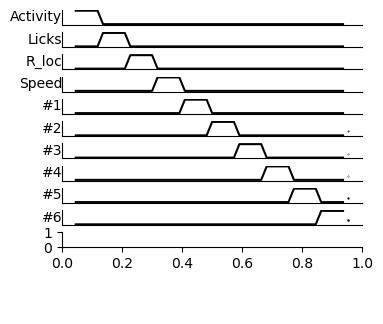

In [9]:
def plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None):
    GLM_params = {}

    # Initialize the weights array with zeros for all variables
    all_weights = np.zeros(len(variable_list))
    
    if animal == 'best' or neuron == 'best':
        best_R2 = -np.inf
        best_animal = None
        best_neuron = None
        for animal_key in reorganized_data:
            GLM_params[animal_key] = {}
            for i, neuron_data in enumerate(reorganized_data[animal_key]):
                neuron_data = reorganized_data[animal_key][i][:, :, 1:]  # Remove the 0th index (neuron activity)
                neuron_data = neuron_data[:, :, ~np.isnan(neuron_data).any(axis=(0, 1))]

                # Hardcode indices to remove: 0th for activity, next 3 for Licks, R_loc, Speed
                indices_to_remove = [0, 1, 2, 4]
                remaining_indices = list(range(4, neuron_data.shape[1]))

                # Filter the data to keep only the remaining indices (which represent position)
                neuron_data_filtered = neuron_data[:, remaining_indices, :]

                min_val = np.min(neuron_data, axis=(0, 2), keepdims=True)
                max_val = np.max(neuron_data, axis=(0, 2), keepdims=True)
                neuron_data = (neuron_data - min_val) / (max_val - min_val)

                flattened_data_filtered = []
                for j in range(neuron_data_filtered.shape[1]):
                    flattened_data_filtered.append(neuron_data_filtered[:, j].flatten())

                flattened_data_filtered = np.stack(flattened_data_filtered, axis=1)

                # Combine normalized neuron activity with filtered features
                flattened_data_filtered = np.column_stack((neuron_data[:, 0, :].flatten(), flattened_data_filtered))

                if np.isnan(flattened_data_filtered).any():
                    print("nans in flattened_data_filtered")
                    continue

                if flattened_data_filtered.shape[1] <= 1:
                    print("No features available after preprocessing")
                    continue

                neuron_activity_flattened = neuron_data[:, 0, :].flatten()

                # Train GLM using only the position data
                design_matrix_X = flattened_data_filtered[:, 1:]  # Use filtered variables (skip the first column)
                print(f" design matrix x : {design_matrix_X}")
                model = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 5000], cv=None)
                model.fit(design_matrix_X, neuron_activity_flattened)

                # After fitting the model, assign the weights to the all_weights array
                for idx, included_index in enumerate(remaining_indices):
                    all_weights[included_index] = model.coef_[idx]

                predicted_activity = model.predict(design_matrix_X)
                predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

                R2 = model.score(design_matrix_X, neuron_activity_flattened)
                pearson_R = np.corrcoef(predicted_activity, neuron_activity_flattened)[0, 1]

                GLM_params[animal_key][i] = {
                    'weights': model.coef_,
                    'intercept': model.intercept_,
                    'R2': R2,
                    'R2_trialavg': pearson_R ** 2,
                    'model': model
                }
                
                if R2 > best_R2:
                    best_R2 = R2
                    best_animal = animal_key
                    best_neuron = i

        animal = best_animal
        neuron = best_neuron

        weights = GLM_params[animal][neuron]['weights']
        print(f"shape neuron_data_filtered {neuron_data_filtered.shape}")
        print(f"weights shape: {weights.shape}")
        
        # Ensure excluded variables have zero weights
        all_weights[indices_to_remove] = 0 

        fig = plt.figure(figsize=(10, 8))
        axes = gs.GridSpec(nrows=1, ncols=1, left=0, right=0.3, bottom=0.5)
        ax = fig.add_subplot(axes[0])
        ax.axis('off')

        # Calculate the average of the selected subset variables (position bins)
        avg_variables = np.mean(neuron_data_filtered, axis=2)
        print(f"  avg_variables shape {avg_variables.shape}")
        
        var_labels_all = [f"{var}" for var in variable_list]
            
        def plotting_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None):
            fig = ax.get_figure()

            # Define height ratios for each variable subplot
            height_ratios = np.ones(len(keep_vars_list))

            # Set up the grid for subplots
            axes = gs.GridSpecFromSubplotSpec(nrows=len(keep_vars_list), ncols=1, subplot_spec=ax, hspace=0.5, height_ratios=height_ratios)

            # Iterate through the variables and plot each one
            for i in range(len(keep_vars_list)):
                sub_ax = fig.add_subplot(axes[i])
                sub_ax.plot(avg_variables[:, i], color='k')  # Ensure correct indexing to plot the right variable

                # Set labels and ticks
                sub_ax.set_ylabel(keep_vars_list[i], rotation=0, ha='right', va='center', labelpad=0)
                sub_ax.set_xticks([])
                sub_ax.set_yticks([])

                # Plot weights as scatter points if provided
                if weights is not None:
                    sub_ax.scatter([50], [0.3], c='k', s=abs(weights[i]) * 20)

            # Set x-axis labels for the bottom plot
            sub_ax.set_xlabel('Position', labelpad=-10)
            sub_ax.set_xticks([0, 50])

            # Draw vertical line across all plots (for visual separation)
            overlay_ax = fig.add_subplot(axes[:])
            overlay_ax.vlines(24.5, 0, 1, linestyles='--', color='r')
            overlay_ax.set_xlim([0, 49])
            overlay_ax.set_ylim([0, 1])
            overlay_ax.axis('off')
            overlay_ax.patch.set_alpha(0)

        # Plot the data
        plotting_example_neuron_variables(avg_variables, var_labels_all, ax=ax, weights=all_weights)


    axes = gs.GridSpec(nrows=1, ncols=1, left=0.3, right=0.54, bottom=0.5)
    ax = fig.add_subplot(axes[0])
    ax.axis('off')
    y1 = np.linspace(-0.54, -1.86, 3).tolist()
    y2 = np.linspace(-2.28, -6, 10).tolist()
    y = y1 + y2
    w_max = np.max(np.abs(weights))
    for i, w in enumerate(weights):
        if abs(w) < 0.05:
            line, = ax.plot([0, 1], [y[i], -3.4], color='lightgray', linestyle='--', linewidth=1)
        elif w < 0:
            line, = ax.plot([0, 1], [y[i], -3.4], color='deepskyblue', linewidth=abs(w/w_max) * 4)
        else:
            line, = ax.plot([0, 1], [y[i], -3.4], color='black', linewidth=abs(w/w_max) * 4)
        line.set_solid_capstyle('round')
    ax.set_ylim([-6, 0])
    ax.plot([0, 0], [0, 0], color='lightgray', linewidth=1.1, linestyle='--', label='Small weights')
    ax.plot([0, 0], [0, 0], color='deepskyblue', linewidth=1.1, label='Negative weights')
    ax.plot([0, 0], [0, 0], color='black', linewidth=1.1, label='Positive weights')
    ax.legend(fontsize=10, loc='upper right', frameon=False, handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderpad=0)

    glm_model = GLM_params[animal][neuron]['model']
    flattened_input_variables = flattened_data_filtered[:, 1:]
    predicted_activity = glm_model.predict(flattened_input_variables)

    predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

    neuron_activity = neuron_data[:, 0, :]

    predicted_activity = predicted_activity.reshape(neuron_activity.shape)
    avg_predicted_activity = np.mean(predicted_activity, axis=1)
    std_predicted_activity = np.std(predicted_activity, axis=1)
    sem_predicted_activity = std_predicted_activity / np.sqrt(predicted_activity.shape[1])

    avg_neuron_activity = np.mean(neuron_activity, axis=1)
    std_neuron_activity = np.std(neuron_activity, axis=1)
    sem_neuron_activity = std_neuron_activity / np.sqrt(neuron_activity.shape[1])

    pearson_R = np.corrcoef(avg_predicted_activity, avg_neuron_activity)[0, 1]
    print("pearson R2 average:", pearson_R ** 2)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.61, right=1, top=0.8, bottom=0.55)
    ax = fig.add_subplot(axes[0])
    ax.plot(avg_predicted_activity, label='GLM prediction', c='gray', linestyle='--')
    ax.plot(avg_neuron_activity, label='Actual activity', c='k')
    ax.fill_between(np.arange(avg_neuron_activity.shape[0]), avg_neuron_activity-sem_neuron_activity, avg_neuron_activity+sem_neuron_activity, alpha=0.1, color='k')
    ax.fill_between(np.arange(avg_predicted_activity.shape[0]), avg_predicted_activity-sem_predicted_activity, avg_predicted_activity+sem_predicted_activity, alpha=0.1, color='gray')
    ax.set_xlabel("Position")
    ax.set_xticks([0, 50])
    ax.set_ylabel("dF/F activity (Min-Max Scaled)")
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.2))

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0.3, right=1)
    ax = fig.add_subplot(axes[0])

    def plot_GLM_summary_data(GLM_params, spatial_bin_labels, ax):
        jitter = 0.1

        animal_averages = []

        for animal_key in GLM_params:
            neuron_weights = []
            for neuron_nr in GLM_params[animal_key]:
                weights = GLM_params[animal_key][neuron_nr]['weights']
                variable_indices = np.arange(len(weights))

                jittered_x = variable_indices + np.random.uniform(-jitter, jitter, len(weights))
                ax.scatter(jittered_x, weights, color='grey', alpha=0.2, s=10)

                neuron_weights.append(weights)

            neuron_weights = np.array(neuron_weights)
            mean_weights = np.mean(neuron_weights, axis=0)
            animal_averages.append(mean_weights)
            ax.scatter(range(len(spatial_bin_labels)), mean_weights, color='black', label=f'Animal {animal_key}', s=20)

        animal_averages = np.array(animal_averages)
        global_mean = np.mean(animal_averages, axis=0)
        global_std = np.std(animal_averages, axis=0)
        ax.errorbar(np.arange(len(spatial_bin_labels)) - 0.15, global_mean, yerr=global_std, fmt='o', color='red', ecolor='red', capsize=5, label='Average of all animals', markersize=7)

        ax.set_xticks(np.arange(len(spatial_bin_labels)))
        ax.set_xticklabels(spatial_bin_labels, rotation=45, ha='right')
        ax.set_ylabel('Weights')
        ax.hlines(0, -0.5, len(weights) - 0.5, linestyles='--', color='black', alpha=0.5)
        ax.set_xlim([-0.5, len(weights) - 0.5])

    plot_GLM_summary_data(GLM_params, spatial_bin_labels, ax)

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0., right=0.2)
    ax = fig.add_subplot(axes[0])
    plot_R2_distribution(GLM_params, ax=ax)

    if model_name is not None:
        fig.savefig(f"figures/GLM_regression_{model_name}_{animal}_{neuron}.png", bbox_inches='tight', dpi=300)


plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None)


 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
 design matrix x : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 

NameError: name 'spatial_bin_labels' is not defined

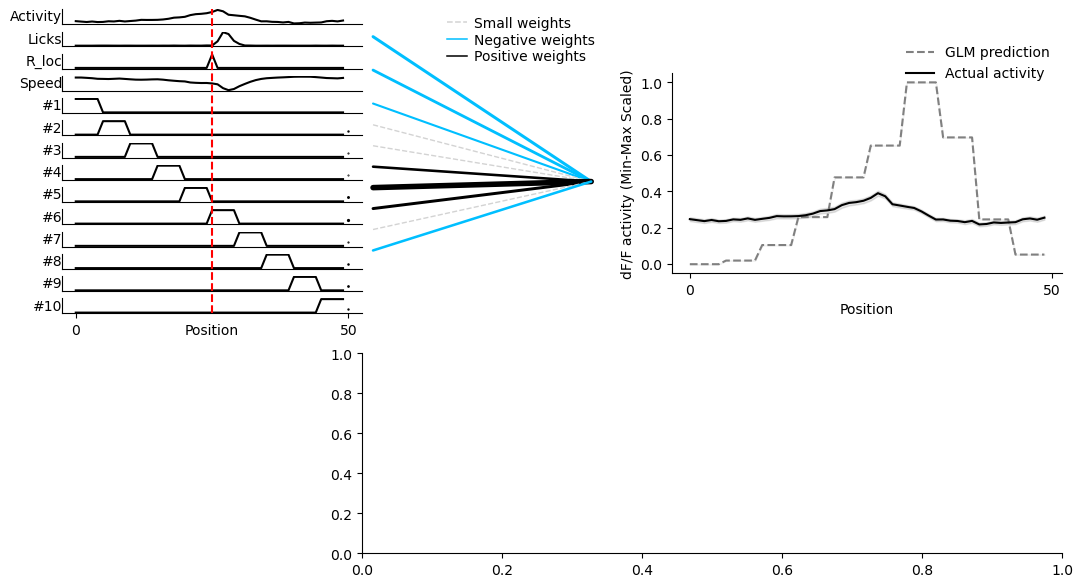

In [10]:
def plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None):
    GLM_params = {}

    # Initialize the weights array with zeros for all variables
    all_weights = np.zeros(len(variable_list))
    
    if animal == 'best' or neuron == 'best':
        best_R2 = -np.inf
        best_animal = None
        best_neuron = None
        for animal_key in reorganized_data:
            GLM_params[animal_key] = {}
            for i, neuron_data in enumerate(reorganized_data[animal_key]):
                neuron_data = reorganized_data[animal_key][i][:, :, 1:]  # Remove the 0th index (neuron activity)
                neuron_data = neuron_data[:, :, ~np.isnan(neuron_data).any(axis=(0, 1))]

                # Hardcode indices to remove: 0th for activity, next 3 for Licks, R_loc, Speed
                indices_to_remove = [0, 1, 2, 4]
                remaining_indices = list(range(4, neuron_data.shape[1]))

                # Copy the original data for plotting (all variables)
                neuron_data_full = neuron_data.copy()

                # Filter the data to keep only the remaining indices (which represent position)
                neuron_data_filtered = neuron_data[:, remaining_indices, :]

                min_val = np.min(neuron_data_filtered, axis=(0, 2), keepdims=True)
                max_val = np.max(neuron_data_filtered, axis=(0, 2), keepdims=True)
                neuron_data_filtered = (neuron_data_filtered - min_val) / (max_val - min_val)

                flattened_data_filtered = []
                for j in range(neuron_data_filtered.shape[1]):
                    flattened_data_filtered.append(neuron_data_filtered[:, j].flatten())

                flattened_data_filtered = np.stack(flattened_data_filtered, axis=1)

                # Combine normalized neuron activity with filtered features
                flattened_data_filtered = np.column_stack((neuron_data[:, 0, :].flatten(), flattened_data_filtered))

                if np.isnan(flattened_data_filtered).any():
                    print("nans in flattened_data_filtered")
                    continue

                if flattened_data_filtered.shape[1] <= 1:
                    print("No features available after preprocessing")
                    continue

                neuron_activity_flattened = neuron_data[:, 0, :].flatten()

                # Train GLM using only the position data
                design_matrix_X = flattened_data_filtered[:, 1:]  # Use filtered variables (skip the first column)
                print(f" design matrix x : {design_matrix_X}")
                model = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 5000], cv=None)
                model.fit(design_matrix_X, neuron_activity_flattened)

                # After fitting the model, assign the weights to the all_weights array
                for idx, included_index in enumerate(remaining_indices):
                    all_weights[included_index] = model.coef_[idx]

                predicted_activity = model.predict(design_matrix_X)
                predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

                R2 = model.score(design_matrix_X, neuron_activity_flattened)
                pearson_R = np.corrcoef(predicted_activity, neuron_activity_flattened)[0, 1]

                GLM_params[animal_key][i] = {
                    'weights': model.coef_,
                    'intercept': model.intercept_,
                    'R2': R2,
                    'R2_trialavg': pearson_R ** 2,
                    'model': model
                }
                
                if R2 > best_R2:
                    best_R2 = R2
                    best_animal = animal_key
                    best_neuron = i

        animal = best_animal
        neuron = best_neuron

        weights = GLM_params[animal][neuron]['weights']
        print(f"shape neuron_data_filtered {neuron_data_filtered.shape}")
        print(f"weights shape: {weights.shape}")
        
        # Ensure excluded variables have zero weights
        all_weights[indices_to_remove] = 0 

        fig = plt.figure(figsize=(10, 8))
        axes = gs.GridSpec(nrows=1, ncols=1, left=0, right=0.3, bottom=0.5)
        ax = fig.add_subplot(axes[0])
        ax.axis('off')

        # Calculate the average of the full dataset (all variables)
        avg_variables = np.mean(neuron_data_full, axis=2)  # Using full dataset here
        print(f"  avg_variables shape {avg_variables.shape}")
        
        var_labels_all = [f"{var}" for var in variable_list]
            
        def plotting_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None):
            fig = ax.get_figure()

            # Define height ratios for each variable subplot
            height_ratios = np.ones(len(keep_vars_list))

            # Set up the grid for subplots
            axes = gs.GridSpecFromSubplotSpec(nrows=len(keep_vars_list), ncols=1, subplot_spec=ax, hspace=0.5, height_ratios=height_ratios)

            # Iterate through the variables and plot each one
            for i in range(len(keep_vars_list)):
                sub_ax = fig.add_subplot(axes[i])
                sub_ax.plot(avg_variables[:, i], color='k')  # Ensure correct indexing to plot the right variable

                # Set labels and ticks
                sub_ax.set_ylabel(keep_vars_list[i], rotation=0, ha='right', va='center', labelpad=0)
                sub_ax.set_xticks([])
                sub_ax.set_yticks([])

                # Plot weights as scatter points if provided
                if weights is not None:
                    sub_ax.scatter([50], [0.3], c='k', s=abs(weights[i]) * 20)

            # Set x-axis labels for the bottom plot
            sub_ax.set_xlabel('Position', labelpad=-10)
            sub_ax.set_xticks([0, 50])

            # Draw vertical line across all plots (for visual separation)
            overlay_ax = fig.add_subplot(axes[:])
            overlay_ax.vlines(24.5, 0, 1, linestyles='--', color='r')
            overlay_ax.set_xlim([0, 49])
            overlay_ax.set_ylim([0, 1])
            overlay_ax.axis('off')
            overlay_ax.patch.set_alpha(0)

        # Plot the data using the full dataset
        plotting_example_neuron_variables(avg_variables, var_labels_all, ax=ax, weights=all_weights)



    axes = gs.GridSpec(nrows=1, ncols=1, left=0.3, right=0.54, bottom=0.5)
    ax = fig.add_subplot(axes[0])
    ax.axis('off')
    y1 = np.linspace(-0.54, -1.86, 3).tolist()
    y2 = np.linspace(-2.28, -6, 10).tolist()
    y = y1 + y2
    w_max = np.max(np.abs(weights))
    for i, w in enumerate(weights):
        if abs(w) < 0.05:
            line, = ax.plot([0, 1], [y[i], -3.4], color='lightgray', linestyle='--', linewidth=1)
        elif w < 0:
            line, = ax.plot([0, 1], [y[i], -3.4], color='deepskyblue', linewidth=abs(w/w_max) * 4)
        else:
            line, = ax.plot([0, 1], [y[i], -3.4], color='black', linewidth=abs(w/w_max) * 4)
        line.set_solid_capstyle('round')
    ax.set_ylim([-6, 0])
    ax.plot([0, 0], [0, 0], color='lightgray', linewidth=1.1, linestyle='--', label='Small weights')
    ax.plot([0, 0], [0, 0], color='deepskyblue', linewidth=1.1, label='Negative weights')
    ax.plot([0, 0], [0, 0], color='black', linewidth=1.1, label='Positive weights')
    ax.legend(fontsize=10, loc='upper right', frameon=False, handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderpad=0)

    glm_model = GLM_params[animal][neuron]['model']
    flattened_input_variables = flattened_data_filtered[:, 1:]
    predicted_activity = glm_model.predict(flattened_input_variables)

    predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

    neuron_activity = neuron_data[:, 0, :]

    predicted_activity = predicted_activity.reshape(neuron_activity.shape)
    avg_predicted_activity = np.mean(predicted_activity, axis=1)
    std_predicted_activity = np.std(predicted_activity, axis=1)
    sem_predicted_activity = std_predicted_activity / np.sqrt(predicted_activity.shape[1])

    avg_neuron_activity = np.mean(neuron_activity, axis=1)
    std_neuron_activity = np.std(neuron_activity, axis=1)
    sem_neuron_activity = std_neuron_activity / np.sqrt(neuron_activity.shape[1])

    pearson_R = np.corrcoef(avg_predicted_activity, avg_neuron_activity)[0, 1]
    print("pearson R2 average:", pearson_R ** 2)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.61, right=1, top=0.8, bottom=0.55)
    ax = fig.add_subplot(axes[0])
    ax.plot(avg_predicted_activity, label='GLM prediction', c='gray', linestyle='--')
    ax.plot(avg_neuron_activity, label='Actual activity', c='k')
    ax.fill_between(np.arange(avg_neuron_activity.shape[0]), avg_neuron_activity-sem_neuron_activity, avg_neuron_activity+sem_neuron_activity, alpha=0.1, color='k')
    ax.fill_between(np.arange(avg_predicted_activity.shape[0]), avg_predicted_activity-sem_predicted_activity, avg_predicted_activity+sem_predicted_activity, alpha=0.1, color='gray')
    ax.set_xlabel("Position")
    ax.set_xticks([0, 50])
    ax.set_ylabel("dF/F activity (Min-Max Scaled)")
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.2))

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0.3, right=1)
    ax = fig.add_subplot(axes[0])

    def plot_GLM_summary_data(GLM_params, spatial_bin_labels, ax):
        jitter = 0.1

        animal_averages = []

        for animal_key in GLM_params:
            neuron_weights = []
            for neuron_nr in GLM_params[animal_key]:
                weights = GLM_params[animal_key][neuron_nr]['weights']
                variable_indices = np.arange(len(weights))

                jittered_x = variable_indices + np.random.uniform(-jitter, jitter, len(weights))
                ax.scatter(jittered_x, weights, color='grey', alpha=0.2, s=10)

                neuron_weights.append(weights)

            neuron_weights = np.array(neuron_weights)
            mean_weights = np.mean(neuron_weights, axis=0)
            animal_averages.append(mean_weights)
            ax.scatter(range(len(spatial_bin_labels)), mean_weights, color='black', label=f'Animal {animal_key}', s=20)

        animal_averages = np.array(animal_averages)
        global_mean = np.mean(animal_averages, axis=0)
        global_std = np.std(animal_averages, axis=0)
        ax.errorbar(np.arange(len(spatial_bin_labels)) - 0.15, global_mean, yerr=global_std, fmt='o', color='red', ecolor='red', capsize=5, label='Average of all animals', markersize=7)

        ax.set_xticks(np.arange(len(spatial_bin_labels)))
        ax.set_xticklabels(spatial_bin_labels, rotation=45, ha='right')
        ax.set_ylabel('Weights')
        ax.hlines(0, -0.5, len(weights) - 0.5, linestyles='--', color='black', alpha=0.5)
        ax.set_xlim([-0.5, len(weights) - 0.5])

    plot_GLM_summary_data(GLM_params, spatial_bin_labels, ax)

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0., right=0.2)
    ax = fig.add_subplot(axes[0])
    plot_R2_distribution(GLM_params, ax=ax)

    if model_name is not None:
        fig.savefig(f"figures/GLM_regression_{model_name}_{animal}_{neuron}.png", bbox_inches='tight', dpi=300)


plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None)




 design matrix x : [[0.24829977 0.         0.         ... 0.         0.         0.        ]
 [0.19725753 0.         0.         ... 0.         0.         0.        ]
 [0.5230661  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.3685278  0.         0.         ... 0.         0.         1.        ]
 [0.0775537  0.         0.         ... 0.         0.         1.        ]
 [0.20803165 0.         0.         ... 0.         0.         1.        ]]
 design matrix x : [[0.24829977 0.         0.         ... 0.         0.         0.        ]
 [0.19725753 0.         0.         ... 0.         0.         0.        ]
 [0.5230661  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.3685278  0.         0.         ... 0.         0.         1.        ]
 [0.0775537  0.         0.         ... 0.         0.         1.        ]
 [0.20803165 0.         0.         ... 0.         0.         1.        ]]
 design matrix x : [[0.24829977 0.         0.         ... 0.         0.   

 design matrix x : [[0.49920615 0.         0.         ... 0.         0.         0.        ]
 [0.70738145 0.         0.         ... 0.         0.         0.        ]
 [0.55867745 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.64683383 0.         0.         ... 0.         0.         1.        ]
 [0.62271558 0.         0.         ... 0.         0.         1.        ]
 [0.50744415 0.         0.         ... 0.         0.         1.        ]]
 design matrix x : [[0.49920615 0.         0.         ... 0.         0.         0.        ]
 [0.70738145 0.         0.         ... 0.         0.         0.        ]
 [0.55867745 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.64683383 0.         0.         ... 0.         0.         1.        ]
 [0.62271558 0.         0.         ... 0.         0.         1.        ]
 [0.50744415 0.         0.         ... 0.         0.         1.        ]]
 design matrix x : [[0.49920615 0.         0.         ... 0.         0.   

 design matrix x : [[0.57140857 0.         0.         ... 0.         0.         0.        ]
 [0.49583146 0.         0.         ... 0.         0.         0.        ]
 [0.44780068 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.44188054 0.         0.         ... 0.         0.         1.        ]
 [0.62771624 0.         0.         ... 0.         0.         1.        ]
 [0.31891288 0.         0.         ... 0.         0.         1.        ]]
 design matrix x : [[0.57140857 0.         0.         ... 0.         0.         0.        ]
 [0.49583146 0.         0.         ... 0.         0.         0.        ]
 [0.44780068 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.44188054 0.         0.         ... 0.         0.         1.        ]
 [0.62771624 0.         0.         ... 0.         0.         1.        ]
 [0.31891288 0.         0.         ... 0.         0.         1.        ]]
 design matrix x : [[0.57140857 0.         0.         ... 0.         0.   

NameError: name 'spatial_bin_labels' is not defined

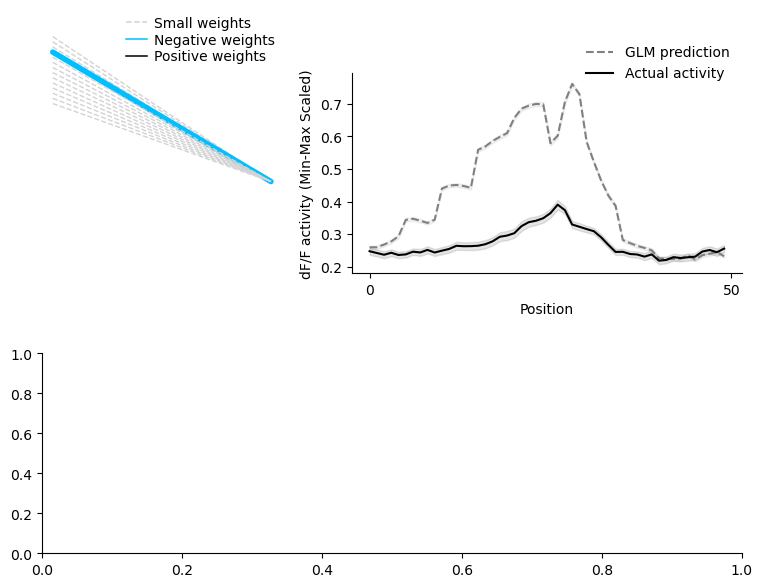

In [11]:
def plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None):
    GLM_params = {}

    # Initialize the weights array with zeros for all variables
    all_weights = np.zeros(len(variable_list))
    
    if animal == 'best' or neuron == 'best':
        best_R2 = -np.inf
        best_animal = None
        best_neuron = None
        for animal_key in reorganized_data:
            GLM_params[animal_key] = {}
            for i, neuron_data in enumerate(reorganized_data[animal_key]):
                neuron_data = reorganized_data[animal_key][i][:, :, 1:]  # Remove the 0th index (neuron activity)
                neuron_data = neuron_data[:, :, ~np.isnan(neuron_data).any(axis=(0, 1))]

                # Hardcode indices to remove: 0th for activity, next 3 for Licks, R_loc, Speed
                indices_to_remove = [0, 1, 2, 4]
                remaining_indices = [idx for idx in range(len(variable_list)) if idx not in indices_to_remove]

                # Filter the data to keep only the remaining indices (which represent position)
                neuron_data_filtered = neuron_data[:, remaining_indices, :]

                min_val = np.min(neuron_data_filtered, axis=(0, 2), keepdims=True)
                max_val = np.max(neuron_data_filtered, axis=(0, 2), keepdims=True)
                neuron_data_filtered = (neuron_data_filtered - min_val) / (max_val - min_val)

                flattened_data_filtered = []
                for j in range(neuron_data_filtered.shape[1]):
                    flattened_data_filtered.append(neuron_data_filtered[:, j].flatten())

                flattened_data_filtered = np.stack(flattened_data_filtered, axis=1)

                # Combine normalized neuron activity with filtered features
                flattened_data_filtered = np.column_stack((neuron_data[:, 0, :].flatten(), flattened_data_filtered))

                if np.isnan(flattened_data_filtered).any():
                    print("nans in flattened_data_filtered")
                    continue

                if flattened_data_filtered.shape[1] <= 1:
                    print("No features available after preprocessing")
                    continue

                neuron_activity_flattened = neuron_data[:, 0, :].flatten()

                # Train GLM using only the position data
                design_matrix_X = flattened_data_filtered[:, 1:]  # Use filtered variables (skip the first column)
                model = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 5000], cv=None)
                model.fit(design_matrix_X, neuron_activity_flattened)

                # After fitting the model, assign the weights to the all_weights array
                for idx, included_index in enumerate(remaining_indices):
                    all_weights[included_index] = model.coef_[idx]

                predicted_activity = model.predict(design_matrix_X)
                predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

                R2 = model.score(design_matrix_X, neuron_activity_flattened)
                pearson_R = np.corrcoef(predicted_activity, neuron_activity_flattened)[0, 1]

                GLM_params[animal_key][i] = {
                    'weights': model.coef_,
                    'intercept': model.intercept_,
                    'R2': R2,
                    'R2_trialavg': pearson_R ** 2,
                    'model': model
                }
                
                if R2 > best_R2:
                    best_R2 = R2
                    best_animal = animal_key
                    best_neuron = i

        animal = best_animal
        neuron = best_neuron

        # Ensure excluded variables have zero weights
        all_weights[indices_to_remove] = 0 

        fig = plt.figure(figsize=(10, 8))
        axes = gs.GridSpec(nrows=1, ncols=1, left=0.3, right=0.54, bottom=0.5)
        ax = fig.add_subplot(axes[0])
        ax.axis('off')

        # Plot the weights with all variables included
        y1 = np.linspace(-0.54, -1.86, len(variable_list)).tolist()
        w_max = np.max(np.abs(all_weights))
        for i, w in enumerate(all_weights):
            if abs(w) < 0.05:
                line, = ax.plot([0, 1], [y1[i], -3.4], color='lightgray', linestyle='--', linewidth=1)
            elif w < 0:
                line, = ax.plot([0, 1], [y1[i], -3.4], color='deepskyblue', linewidth=abs(w/w_max) * 4)
            else:
                line, = ax.plot([0, 1], [y1[i], -3.4], color='black', linewidth=abs(w/w_max) * 4)
            line.set_solid_capstyle('round')
        ax.set_ylim([-6, 0])
        ax.plot([0, 0], [0, 0], color='lightgray', linewidth=1.1, linestyle='--', label='Small weights')
        ax.plot([0, 0], [0, 0], color='deepskyblue', linewidth=1.1, label='Negative weights')
        ax.plot([0, 0], [0, 0], color='black', linewidth=1.1, label='Positive weights')
        ax.legend(fontsize=10, loc='upper right', frameon=False, handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderpad=0)

        
    glm_model = GLM_params[animal][neuron]['model']
    flattened_input_variables = flattened_data_filtered[:, 1:]
    predicted_activity = glm_model.predict(flattened_input_variables)

    predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))

    neuron_activity = neuron_data[:, 0, :]

    predicted_activity = predicted_activity.reshape(neuron_activity.shape)
    avg_predicted_activity = np.mean(predicted_activity, axis=1)
    std_predicted_activity = np.std(predicted_activity, axis=1)
    sem_predicted_activity = std_predicted_activity / np.sqrt(predicted_activity.shape[1])

    avg_neuron_activity = np.mean(neuron_activity, axis=1)
    std_neuron_activity = np.std(neuron_activity, axis=1)
    sem_neuron_activity = std_neuron_activity / np.sqrt(neuron_activity.shape[1])

    pearson_R = np.corrcoef(avg_predicted_activity, avg_neuron_activity)[0, 1]
    print("pearson R2 average:", pearson_R ** 2)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.61, right=1, top=0.8, bottom=0.55)
    ax = fig.add_subplot(axes[0])
    ax.plot(avg_predicted_activity, label='GLM prediction', c='gray', linestyle='--')
    ax.plot(avg_neuron_activity, label='Actual activity', c='k')
    ax.fill_between(np.arange(avg_neuron_activity.shape[0]), avg_neuron_activity-sem_neuron_activity, avg_neuron_activity+sem_neuron_activity, alpha=0.1, color='k')
    ax.fill_between(np.arange(avg_predicted_activity.shape[0]), avg_predicted_activity-sem_predicted_activity, avg_predicted_activity+sem_predicted_activity, alpha=0.1, color='gray')
    ax.set_xlabel("Position")
    ax.set_xticks([0, 50])
    ax.set_ylabel("dF/F activity (Min-Max Scaled)")
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.2))

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0.3, right=1)
    ax = fig.add_subplot(axes[0])

    def plot_GLM_summary_data(GLM_params, spatial_bin_labels, ax):
        jitter = 0.1

        animal_averages = []

        for animal_key in GLM_params:
            neuron_weights = []
            for neuron_nr in GLM_params[animal_key]:
                weights = GLM_params[animal_key][neuron_nr]['weights']
                variable_indices = np.arange(len(weights))

                jittered_x = variable_indices + np.random.uniform(-jitter, jitter, len(weights))
                ax.scatter(jittered_x, weights, color='grey', alpha=0.2, s=10)

                neuron_weights.append(weights)

            neuron_weights = np.array(neuron_weights)
            mean_weights = np.mean(neuron_weights, axis=0)
            animal_averages.append(mean_weights)
            ax.scatter(range(len(spatial_bin_labels)), mean_weights, color='black', label=f'Animal {animal_key}', s=20)

        animal_averages = np.array(animal_averages)
        global_mean = np.mean(animal_averages, axis=0)
        global_std = np.std(animal_averages, axis=0)
        ax.errorbar(np.arange(len(spatial_bin_labels)) - 0.15, global_mean, yerr=global_std, fmt='o', color='red', ecolor='red', capsize=5, label='Average of all animals', markersize=7)

        ax.set_xticks(np.arange(len(spatial_bin_labels)))
        ax.set_xticklabels(spatial_bin_labels, rotation=45, ha='right')
        ax.set_ylabel('Weights')
        ax.hlines(0, -0.5, len(weights) - 0.5, linestyles='--', color='black', alpha=0.5)
        ax.set_xlim([-0.5, len(weights) - 0.5])

    plot_GLM_summary_data(GLM_params, spatial_bin_labels, ax)

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0., right=0.2)
    ax = fig.add_subplot(axes[0])
    plot_R2_distribution(GLM_params, ax=ax)

    if model_name is not None:
        fig.savefig(f"figures/GLM_regression_{model_name}_{animal}_{neuron}.png", bbox_inches='tight', dpi=300)


plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', model_name=None)




In [15]:
from GLM_regression import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'legend.frameon': False})

GLM_params = fit_GLM(reorganized_data, quintile=None, regression='ridge', alphas=None)
model.coef[:3] 


# Load data
filepath = "NDNFindivsomata_GLM.mat"
reorganized_data, variable_list = load_data(filepath)
print(f"variable_list: {variable_list}")

# variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']
vars_to_remove = [3] #speed

def new_fn(GLM_params, vars_to_remove):
    new_GLM_params = GLM_params.copy()
    model.coef[vars_to_remove] = 0
    model.intercept[vars_to_remove] = 0 
    
    return filtered_GLM_dictionary 

NameError: name 'model' is not defined

In [8]:
from GLM_regression import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'legend.frameon': False})

GLM_params = fit_GLM(reorganized_data, quintile=None, regression='ridge', alphas=None) 


# Load data
filepath = "NDNFindivsomata_GLM.mat"
reorganized_data, variable_list = load_data(filepath)
print(f"variable_list: {variable_list}")



# variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']
vars_to_remove = [2] #speed


def remove_variables_from_glm(GLM_params, vars_to_remove):
  
    modified_GLM_params = {}

    for animal_key, neurons in GLM_params.items():
        modified_GLM_params[animal_key] = {}
        for neuron_idx, params in neurons.items():
            print(f" GLM_params[weights][vars_to_remove] {GLM_params[weights][vars_to_remove]}")
            # Copy the existing GLM parameters
            new_params = params.copy()
            # Zero out the weights for the variables to remove
            for var in vars_to_remove:
                new_params['weights'][var] = 0
            modified_GLM_params[animal_key][neuron_idx] = new_params
            print(f" modified_GLM_params[weights][vars_to_remove] {modified_GLM_params[weights][vars_to_remove]}")
    
    return modified_GLM_params

remove_variables_from_glm(GLM_params, vars_to_remove)


variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']


NameError: name 'weights' is not defined

variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']
Original weights for neuron 0 in animal animal_1: [ 0.59582005  0.66140293 -0.22543015 -0.03530361  0.047156    0.22868639
  0.28131804  0.32172296 -0.39957975 -0.25808119 -0.08250207  0.01556084
 -0.11897763]
Modified weights for neuron 0 in animal animal_1: [ 0.59582005  0.66140293  0.         -0.03530361  0.047156    0.22868639
  0.28131804  0.32172296 -0.39957975 -0.25808119 -0.08250207  0.01556084
 -0.11897763]
Original weights for neuron 1 in animal animal_1: [ 0.65409373  0.65311653  0.10865927  0.02284824  0.04650055  0.1655148
  0.17805324  0.19660784 -0.4800598  -0.17349946  0.06170069  0.06165927
 -0.07932536]
Modified weights for neuron 1 in animal animal_1: [ 0.65409373  0.65311653  0.          0.02284824  0.04650055  0.1655148
  0.17805324  0.19660784 -0.4800598  -0.17349946  0.06170069  0.06165927
 -0.07932536]
Original weights for neuron 2 in animal animal

pearson R2 overall: 0.2062502826482512
pearson R2 average: 0.8790722307611641


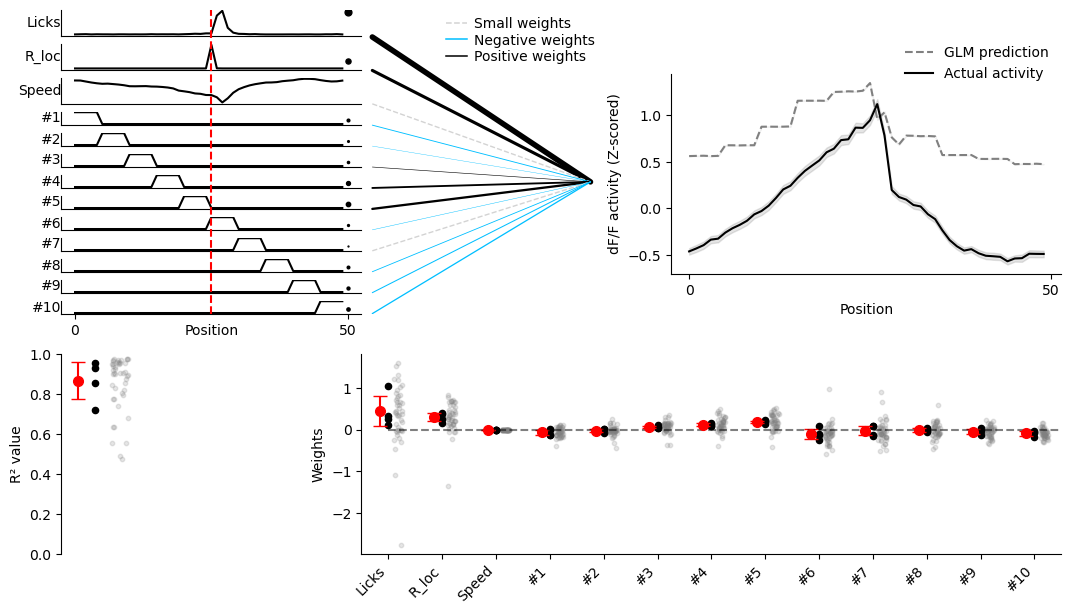

In [9]:
from GLM_regression import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'legend.frameon': False})




# Load data
filepath = "NDNFindivsomata_GLM.mat"
reorganized_data, variable_list = load_data(filepath)
print(f"variable_list: {variable_list}")

GLM_params = fit_GLM(reorganized_data, quintile=None, regression='ridge', alphas=None) 

# variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']
vars_to_remove = [2] #speed
#### always get rid of 0 that is activity 

def remove_variables_from_glm(GLM_params, vars_to_remove):
    modified_GLM_params = {}

    for animal_key, neurons in GLM_params.items():
        modified_GLM_params[animal_key] = {}
        for neuron_idx, params in neurons.items():

            print(f"Original weights for neuron {neuron_idx} in animal {animal_key}: {params['weights']}")
            
            new_params = params.copy()
            
            for var in vars_to_remove:
                new_params['weights'][var] = 0
            
            modified_GLM_params[animal_key][neuron_idx] = new_params
            
  
            print(f"Modified weights for neuron {neuron_idx} in animal {animal_key}: {new_params['weights']}")
    
    return modified_GLM_params


filtered_GLM_params = remove_variables_from_glm(GLM_params, vars_to_remove)

animal='best'
plot_example_neuron(reorganized_data, GLM_params, variable_list, neuron='best', animal='best', model_name=None)


In [5]:
from copy import deepcopy

from GLM_regression import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'legend.frameon': False})




# Load data
filepath = "NDNFindivsomata_GLM.mat"
reorganized_data, variable_list = load_data(filepath)
print(f"variable_list: {variable_list}")

GLM_params = fit_GLM(reorganized_data, quintile=None, regression='ridge', alphas=None) 

# variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']
vars_to_remove = ['Speed'] #speed
#### always get rid of 0 that is activity 





def remove_variables_from_glm(GLM_params, vars_to_remove, variable_list):
    
   

    vars_to_remove = [variable_list[1:].index(var) for var in vars_to_remove]
    
    GLM_params_deepcopy = deepcopy(GLM_params)
    
    modified_GLM_params = {}

    for animal_key, neurons in GLM_params.items():
        modified_GLM_params[animal_key] = {}
        for neuron_idx, params in neurons.items():
            print(f"Original weights for neuron {neuron_idx} in animal {animal_key}: {params['weights']}")
            
            new_params = params.copy()
            
            
            for var in vars_to_remove:
                new_params['weights'][var] = 0
            
            new_params['model'].coef_[vars_to_remove] = 0
            
            modified_GLM_params[animal_key][neuron_idx] = new_params
            
            print(f"Modified weights for neuron {neuron_idx} in animal {animal_key}: {new_params['weights']}")
    
    return modified_GLM_params

filtered_GLM_params = remove_variables_from_glm(GLM_params, vars_to_remove, variable_list)
plot_example_neuron(reorganized_data, GLM_params, variable_list, neuron='best', animal='best', model_name=None)



variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']
Original weights for neuron 0 in animal animal_1: [ 0.59582005  0.66140293 -0.22543015 -0.03530361  0.047156    0.22868639
  0.28131804  0.32172296 -0.39957975 -0.25808119 -0.08250207  0.01556084
 -0.11897763]
Modified weights for neuron 0 in animal animal_1: [ 0.59582005  0.66140293  0.         -0.03530361  0.047156    0.22868639
  0.28131804  0.32172296 -0.39957975 -0.25808119 -0.08250207  0.01556084
 -0.11897763]
Original weights for neuron 1 in animal animal_1: [ 0.65409373  0.65311653  0.10865927  0.02284824  0.04650055  0.1655148
  0.17805324  0.19660784 -0.4800598  -0.17349946  0.06170069  0.06165927
 -0.07932536]
Modified weights for neuron 1 in animal animal_1: [ 0.65409373  0.65311653  0.          0.02284824  0.04650055  0.1655148
  0.17805324  0.19660784 -0.4800598  -0.17349946  0.06170069  0.06165927
 -0.07932536]
Original weights for neuron 2 in animal animal

IndexError: single positional indexer is out-of-bounds